<a href="https://colab.research.google.com/github/psterritt5/biographical-parser/blob/main/biographical_parser_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project description
In this project I used GPT-3.5-turbo to transform unstructured data in the form of a biography to structured data in the form of attribute-value pairs. Given a Wikipedia Biograph like this:

> Jill Tracy Jacobs Biden (born June 3, 1951) is an American educator and the current first lady of the United States as the wife of President Joe Biden. She was the second lady of the United States from 2009 to 2017. Since 2009, Biden has been a professor of English at Northern Virginia Community College.

> She has a bachelor's degree in English and a doctoral degree in education from the University of Delaware, as well as master's degrees in education and English from West Chester University and Villanova University. She taught English and reading in high schools for thirteen years and instructed adolescents with emotional disabilities at a psychiatric hospital. From 1993 to 2008, Biden was an English and writing instructor at Delaware Technical & Community College. Biden is thought to be the first wife of a vice president or president to hold a paying job during her husband's tenure.

> Born in Hammonton, New Jersey, she grew up in Willow Grove, Pennsylvania. She married Joe Biden in 1977, becoming stepmother to Beau and Hunter, his two sons from his first marriage. Biden and her husband also have a daughter together, Ashley Biden, born in 1981. She is the founder of the Biden Breast Health Initiative non-profit organization, co-founder of the Book Buddies program, co-founder of the Biden Foundation, is active in Delaware Boots on the Ground, and with Michelle Obama is co-founder of Joining Forces. She has published a memoir and two children's books.

I created models that would output structured data like:
```
notable_type: First Lady of the United States
name: Jill Biden
gender: female
nationality: American
birth_date: 03 June 1951
birth_place: Hammonton, New Jersey
alma_mater: University of Delaware
occupation: professor of English at Northern Virginia Community College
notable_works: children's books and memoir
main_interests: education, literacy, women's health
partner: Joe Biden
children: Ashley Biden, Beau Biden (stepson), Hunter Biden (stepson)
```

To accomplish this I used the following strategies:


*   Zero shot learning
*   Few shot learning
*   Fine-tuned models

Then measured and compared performance on 3 metrics (recall, precision and f-scores) using a seperate test set.

If you would like to run my code, you may enter your API key below. If you have an OpenAI account, you can generate an API key [here](https://platform.openai.com/api-keys).  

In [ ]:
%%capture
%pip install --upgrade openai
%pip install jsonlines
%pip install wandb

In [ ]:
from getpass import getpass
import openai
import os

print('Enter OpenAI API key:')
openai.api_key = getpass()

os.environ['OPENAI_API_KEY']=openai.api_key

Enter OpenAI API key:
··········


# Load training data & lightly process
Take 200 random samples from the training dataset. When fine-tuning we will use an 80/20 ratio with 200 samples from the training dataset and 50 samples from the test set. This data is mostly intended for fine-tuning, but we will also use a few examples to prompt the few-shot learning model. Processing includes slight reformattting; additional processing will be required for fine-tuning.

In [ ]:
!wget https://raw.githubusercontent.com/artificial-intelligence-class/artificial-intelligence-class.github.io/master/homeworks/large-LMs/SynthBio_train.json

--2024-08-14 12:59:30--  https://raw.githubusercontent.com/artificial-intelligence-class/artificial-intelligence-class.github.io/master/homeworks/large-LMs/SynthBio_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5807118 (5.5M) [text/plain]
Saving to: ‘SynthBio_train.json.1’

SynthBio_train.json 100%[===================>]   5.54M  --.-KB/s    in 0.05s   

2024-08-14 12:59:30 (121 MB/s) - ‘SynthBio_train.json.1’ saved [5807118/5807118]



In [ ]:
# Load a file called 'SynthBio_train.json' which is a list of json objects.

import json
import random

def load_wiki_bio_data(filename='SynthBio_train.json', num_bios=200, randomized=True):
  with open(filename) as f:
    synth_bio_data = json.load(f)
  if randomized:
    random.shuffle(synth_bio_data)
  bios = []
  for data in synth_bio_data:
    notable_type = data['notable_type']
    attributes = "notable_type: {notable_type} | {other_attributes}".format(
        notable_type = notable_type,
        other_attributes = data['serialized_attrs']
    )
    biography = data['biographies'][0]
    bios.append((attributes.replace(" | ", "\n"), biography))
  print('There are ' + str(len(bios)) + ' samples in the training dataset.')
  return bios[:min(num_bios, len(bios))]

wiki_bios = load_wiki_bio_data()
attributes, bio = wiki_bios[0]
print(attributes)
print('---')
bio

There are 2000 samples in the training dataset.
notable_type: musician
name: Albeto Hernandez
birth_name: José Antonio Domínguez
alias: The Black-Skinned Angel
gender: non-binary
birth_date: 25 May 1866
birth_place: Puerto Plata, Dominican Republic
death_date: March 28, 1921
death_place: Santiago, Santiago Province, Dominican Republic
death_cause: flu
resting_place: Cementario Municipal Santiago
instrument: guitar
genre: folk
hometown: Puerto Plata, Dominican Republic
nationality: Dominican
citizenship: Dominican Republic
years_active: 1883-1921
label: Black Angel
associated_acts: Black Angel Orchestra
awards: Grammy Award (1999), Latin Grammy Award (2006)
mother: Mariana Solano
father: Antonio Hernandez
partner: Adela Hernandez
---


'José Antonio Domínguez (25 May 1866 – 28 March 1921) was born in Puerto Plata, Dominican Republic. He was known as "Black-Skinned Angel". He was born to Antonio Hernandez and Mariana Solano. Their Awards are Grammy Award (1999), Latin Grammy Award (2006). His label was Black Angel and associated acts are Black Angel Orchestra. He was active between 1883-1921. They were married to Adela Hernandez. He died in Santiago in 25 May,1921. He died in 1921 in Santiago de los Caballeros. He was buried in the Municipal Cemetery of Santiago.'

# Zero shot learning

Attempt to create a biographical parser using GPT-3.5-turbo using only zero-shot prompting.

## Model

In [ ]:
def parse_bio_zero_shot(bio, *args):
  system_message = {"role" : "system", "content" : ("Given a biography, output a set of attributes and attribute values."
                                                    "Use the strict format attribute_type: attribute_value.")}

  client = openai.OpenAI()
  response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages= [
          system_message,
          {"role" : "user", "content" : bio + "###"}
      ],
      temperature=0.7,
      max_tokens=512,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["###"]
  )
  return response.choices[0].message.content.strip()

## Single Test

We will use a more rigorous test set later. For now, lets verify this zero-shot model is able to provide coherent feedback.

In [ ]:
biography = str(wiki_bios[0][1])
attributes = parse_bio_zero_shot(biography)
print(biography)
print('---')
print(attributes)

Eshan Zaidi (born March 7, 1947) is a retired Qatari hammer thrower. He competed at the 1976 and 1984 Summer Olympics and the 1986 Asian Games. Al Zaidi won the gold medal at the 1982 Asian Games, and silver medals at the 1978 and 1982 Asian Games and 1976 and 1984 Summer Olympics. He also won the 1985 and 1986 Asian Athletics Championships. Zaidi is the second person to throw hammer more than 200 meters. Al Zaidi had a personal best of , which is the Qatari national record. His mother and father are Abdullah al Zaidi,Um Abdullah (née Fahad). He is married to Lea al Sallam.
---
- Name: Eshan Zaidi
- Date of Birth: March 7, 1947
- Nationality: Qatari
- Occupation: Retired hammer thrower
- Olympic Appearances: 1976, 1984
- Asian Games Appearances: 1986, 1978, 1982
- Gold Medals: 1982 Asian Games
- Silver Medals: 1978 Asian Games, 1982 Asian Games, 1976 Summer Olympics, 1984 Summer Olympics
- Asian Athletics Championships: 1985, 1986
- Hammer Throw Personal Best: 200 meters
- National Rec

# Few shot learning

Try to improve upon the results obtained using zero shot learning using few shot learning.

## Model

In [ ]:
import openai
import os
import time

def parse_bio_few_shot(bio, *args):
  ''' few shot prompt = 3 examples from training set in the format:
      {wiki bio} \n---\n {attributes}'''
  few_shot_prompt = ""
  for i in range(1,4):
    few_shot_prompt += wiki_bios[i][1] +'\n---\n' + wiki_bios[i][0]
  few_shot_prompt += '\n---\n'

  system_message = {"role" : "system", "content" : "You should recognize a pattern in the prompts and generate a completion based on that pattern."}

  client = openai.OpenAI()
  response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages= [
          system_message,
          {"role" : "user", "content" : few_shot_prompt + bio + "\n---### "} # simulate a user prompt
      ],
      temperature=0.7,
      max_tokens=1024, # increased num tokens due to length of prompt
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["###"]
  )
  # I recommend putting a short wait after each call,
  # since the rate limit for the platform is 60 requests/min.
  # (This increases to 3000 requests/min after you've been using the platform for 2 days).
  time.sleep(1)

  # the response from OpenAI's API is a JSON object that contains
  # the completion to your prompt plus some other information.  Here's how to access
  # just the text of the completion.
  return response.choices[0].message.content.strip()

## Single Test

Again let's conduct a small test using the same sample as used to test the zero shot model. Note this sample was not used to prompt the few shot model.

In [ ]:
bio = wiki_bios[0][1]
print(bio)
print(parse_bio_few_shot(bio))

Eshan Zaidi (born March 7, 1947) is a retired Qatari hammer thrower. He competed at the 1976 and 1984 Summer Olympics and the 1986 Asian Games. Al Zaidi won the gold medal at the 1982 Asian Games, and silver medals at the 1978 and 1982 Asian Games and 1976 and 1984 Summer Olympics. He also won the 1985 and 1986 Asian Athletics Championships. Zaidi is the second person to throw hammer more than 200 meters. Al Zaidi had a personal best of , which is the Qatari national record. His mother and father are Abdullah al Zaidi,Um Abdullah (née Fahad). He is married to Lea al Sallam.
notable_type: athlete
name: Eshan Zaidi
gender: male
birth_date: 07 March 1947
birth_place: Qatar
occupation: retired hammer thrower
olympics_participation: 1976, 1984
asian_games_participation: 1982 (gold), 1978 & 1982 (silver)
asian_athletics_championships: 1985, 1986
notable_achievement: second person to throw hammer over 200 meters
personal_best: Qatari national record
parents: Abdullah al Zaidi (father), Um Abd

# Fine-tuned model

Try to improve upon the results obtained using zero shot and few shot learning by creating a finely-tuned model.

## Load and process the training data

---



Format the data per the [guidelines](https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset) provided by OpenAI. The basic format for fine-tuning is as follows:

```
{"messages": [{"role": "system", "content": "Explanation for how LLM should behave."}, {"role": "user", "content": "User's prompt 1"}, {"role": "assistant", "content": "Expected response 1."}]}
{"messages": [{"role": "system", "content": "Explanation for how LLM should behave."}, {"role": "user", "content": "User's prompt 2"}, {"role": "assistant", "content": "Expected response 2."}]}
{"messages": [{"role": "system", "content": "Explanation for how LLM should behave."}, {"role": "user", "content": "User's prompt 3"}, {"role": "assistant", "content": "Expected response 3."}]}
...
```

In the code below, I'll extract a prompt that contains the `attributes` variable from the intent determination data, and I'll have the completion be the `biography` variable.

In [ ]:
import json

def create_wikibio_parser_finetuning_data(wikibios, fine_tuning_filename):
  fine_tuning_data = []
  system_message = {"role" : "system", "content" : ("Extract a comprehensive set of attributes and attribute values based on a person's biography.")}

  for attributes, bio in wiki_bios:
    prompt = "{bio}\n---\n".format(bio=bio)
    completion = "{attributes}\n###".format(attributes=attributes)
    data = {"messages" : [system_message, {"role" : "user", "content" : prompt}, {"role" : "assistant", "content" : completion}]}
    fine_tuning_data.append(data)

  random.shuffle(fine_tuning_data)
  with open(fine_tuning_filename, 'w') as out:
    for data in fine_tuning_data:
        out.write(json.dumps(data))
        out.write('\n')

fine_tuning_filename='wikibio_parser_finetuning_data.jsonl'
create_wikibio_parser_finetuning_data(wiki_bios, fine_tuning_filename)

In [ ]:
# Confirm formatting is as intended
def view_finetuning_data(filename):
    with open(filename, 'r') as f:
        for _ in range(2):  # Loop to read the first two lines
            line = f.readline().strip()
            if line:
                data = json.loads(line)
                print(json.dumps(data, indent=2))
view_finetuning_data(fine_tuning_filename)

{
  "messages": [
    {
      "role": "system",
      "content": "Extract a comprehensive set of attributes and attribute values based on a person's biography."
    },
    {
      "role": "user",
      "content": "Boris Lavti\u0146 was a Latvian mountaineer who was born on 28 April 1908 at Jelgava, Latvia. His notable ascents are First ascent of Mount McKinley and Grand Peak and final ascent are Annapurna I and Grand Teton Peak. Lavti\u0146 was born to Lia and Andris. He died on February 18, 2004 at Honolulu, Hawaii due to natural causes and laid at Hale Hoaloha. His partner is Agatha Lavti\u0146a and children are Linda Lavti\u0146a, John Lavti\u0146a and Aibe Lavti\u0146a. Lavtin made partnerships with Tom Brady and starting age is 28.\n---\n"
    },
    {
      "role": "assistant",
      "content": "notable_type: mountaineer\nname: Boris Lavti\u0146\ngender: male\nnationality: Latvian\nbirth_date: 28 April 1908\nbirth_place: Jelgava, Latvia\ndeath_date: February 18, 2004\ndeath_place

## Perform Fine-Tuning

Next, we'll perform fine-tuning with this data using OpenAI.

In [ ]:
# Upload the file to OpenAI's API
client = openai.OpenAI()
client.files.create(
  file=open("wikibio_parser_finetuning_data.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-owTaA05JqzMqaYIPcJRXuTlI', bytes=301181, created_at=1723651062, filename='wikibio_parser_finetuning_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
# Create a fine-tune job. Careful! ($$$)
client.fine_tuning.jobs.create(
  training_file="file-owTaA05JqzMqaYIPcJRXuTlI",
  model="gpt-3.5-turbo",
  hyperparameters={
    #"n_epochs":4,
    "batch_size": 4
  }
)

FineTuningJob(id='ftjob-4L4hFgK1dRstVLXZpacZbbQo', created_at=1723651091, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size=4, learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-FO7UBdYz4LlRN0yvBe7QPqP9', result_files=[], seed=581749237, status='validating_files', trained_tokens=None, training_file='file-owTaA05JqzMqaYIPcJRXuTlI', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
# List 10 fine-tuning jobs
client.fine_tuning.jobs.list(limit=10)

# Retrieve the state of a fine-tune
client.fine_tuning.jobs.retrieve("ftjob-4L4hFgK1dRstVLXZpacZbbQo")

# List up to 10 events from a fine-tuning job
client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-4L4hFgK1dRstVLXZpacZbbQo", limit=10)

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-tlZ77lmhEgFfC2juNMDDwGVp', created_at=1723651091, level='info', message='Validating training file: file-owTaA05JqzMqaYIPcJRXuTlI', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-EqZ7D5HTtDEd61Z6Rw8kV9jO', created_at=1723651091, level='info', message='Created fine-tuning job: ftjob-4L4hFgK1dRstVLXZpacZbbQo', object='fine_tuning.job.event', data={}, type='message')], object='list', has_more=False)

## Single test

parse_bio calls API with the fine-tuned model, and returns a string representing the identified attributes

In [ ]:
def parse_bio_fine_tuned(biography, finetuned_bio_parser_model):
  client = openai.OpenAI()
  prompt = "{biography}\n---\n".format(biography=biography)
  system_message = {"role" : "system", "content" : ("Extract a comprehensive set of attributes and attribute values based on a person's biography.")}
  response = client.chat.completions.create(
      model=finetuned_bio_parser_model,
      messages = [
          system_message,
          {"role" : "user", "content" : prompt}
      ],
      temperature=0.7,
      max_tokens=500,
      top_p=0.8,
      frequency_penalty=0.2,
      presence_penalty=0,
      stop= ['###']
      )
  return response.choices[0].message.content.strip()

Simple test (more comprehensive testing will be performed later). Take one example from the test set and compare the expected response with the response generated by the model:

In [ ]:
finetuned_bio_parser_model="ft:gpt-3.5-turbo-0125:personal::9vZLFYt3"

bio = """("Igor Ivanov was born on October 18, 1970 in Moscow, Russia. His mother is Anastasia Nikolaevna Ivanova, and his father is Nikolay Ivanovich Ivanov. Ivanov is a Russian artist who specializes in oil paintings of portraits, city scenes, still lifes, and flowers. Ivanov attended the Moscow College of Art (now in the Moscow Institute of Painting, Sculpture and Architecture), where he received a bachelor's degree in painting and a master's degree in art history. His notable works include Portraits of Celebrities, Still Life with Flowers, Flowers and Fruit and movement realism. He has received several awards, including the People's Artist of the USSR, Hero of Socialist Labour. Ivanov is also a Professor of the Academy, and he was elected a People's Artist of Russia in 2006. He is married to Alexandra Alexandrovna Vasilieva, and they have two daughters, Alexandra Ivanovna Vasilieva and Anastasia Ivanovna Vasilieva."""

exp_resp = """"{'name': 'Igor Ivanov', 'gender': 'male', 'nationality': 'Russian', 'birth_date': '18 October 1970', 'birth_place': 'Moscow, Russian Soviet Federative Socialist Republic', 'known_for': 'paintings of portraits, city scenes, still lifes, and flowers', 'notable_works': 'Portraits of Celebrities, Still Life with Flowers, Flowers and Fruit', 'movement': 'realism', 'alma_mater': 'the Moscow College of Art (now in the Moscow Institute of Painting, Sculpture and Architecture)', 'awards': "People's Artist of the USSR, Gold Medals, Hero of Socialist Labour", 'elected': "People's Artist of Russia, Professor of the Academy", 'mother': 'Anastasia Nikolaevna Ivanova', 'father': 'Nikolay Ivanovich Ivanov', 'partner': 'Alexandra Alexandrovna Vasilieva', 'children': 'Alexandra Ivanovna Vasilieva, Anastasia Ivanovna Vasilieva', 'notable_type': 'artist'}"""

act_resp = parse_bio_fine_tuned(bio, finetuned_bio_parser_model)
print(exp_resp)
print('---')
print(act_resp)

"{'name': 'Igor Ivanov', 'gender': 'male', 'nationality': 'Russian', 'birth_date': '18 October 1970', 'birth_place': 'Moscow, Russian Soviet Federative Socialist Republic', 'known_for': 'paintings of portraits, city scenes, still lifes, and flowers', 'notable_works': 'Portraits of Celebrities, Still Life with Flowers, Flowers and Fruit', 'movement': 'realism', 'alma_mater': 'the Moscow College of Art (now in the Moscow Institute of Painting, Sculpture and Architecture)', 'awards': "People's Artist of the USSR, Gold Medals, Hero of Socialist Labour", 'elected': "People's Artist of Russia, Professor of the Academy", 'mother': 'Anastasia Nikolaevna Ivanova', 'father': 'Nikolay Ivanovich Ivanov', 'partner': 'Alexandra Alexandrovna Vasilieva', 'children': 'Alexandra Ivanovna Vasilieva, Anastasia Ivanovna Vasilieva', 'notable_type': 'artist'}
---
notable_type: artist
name: Igor Ivanov
gender: male
nationality: Russian
birth_date: 18 October 1970
birth_place: Moscow, Russia
death_date: 
death

# Evaluation

## Set up test suite

Obtain test data

In [ ]:
!wget https://raw.githubusercontent.com/artificial-intelligence-class/artificial-intelligence-class.github.io/master/homeworks/large-LMs/SynthBio_test.json

--2024-08-14 13:02:34--  https://raw.githubusercontent.com/artificial-intelligence-class/artificial-intelligence-class.github.io/master/homeworks/large-LMs/SynthBio_test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 665457 (650K) [text/plain]
Saving to: ‘SynthBio_test.json’

SynthBio_test.json  100%[===================>] 649.86K  --.-KB/s    in 0.02s   

2024-08-14 13:02:34 (29.7 MB/s) - ‘SynthBio_test.json’ saved [665457/665457]



In [ ]:
import json

def load_wiki_bio_test_set(filename='SynthBio_test.json', max_test_items=10, randomized=True):
  """
  Loads our wikibio test set, and returns a list of tuples
  biographies (text), attributes (dictionaires)
  """
  with open(filename) as f:
    synth_bio_data = json.load(f)
  bios = []
  for data in synth_bio_data:
    notable_type = data['notable_type']
    attributes = data['attrs']
    attributes['notable_type'] = notable_type
    biography = data['biographies'][0]
    bios.append((biography, attributes))
  return bios[:min(max_test_items, len(bios))]

def convert_to_dict(predcited_attributes_txt):
  """
  Converts predicted attributes from text format into a dictionary.
  """
  predicted_attributes = {}
  for line in predcited_attributes_txt.split('\n'):
    try:
      attribute, value = line.split(':')
      attribute = attribute.strip().lstrip('- ').strip() # zero shot sometimes adds '- '
      predicted_attributes[attribute] = value.strip()
    except ValueError:
      continue
  return predicted_attributes

In [ ]:
testset_filename = 'SynthBio_test.json'
max_test_items = 50  # 80/20 training split
wiki_bio_test = load_wiki_bio_test_set(testset_filename, max_test_items)

Helper function for computing precision, recall and f-score.

In [ ]:
from collections import Counter

def update_counts(gold_attributes, predicted_attributes, true_positives, false_positives, false_negatives, all_attributes):
  # Compute true positives and false negatives
  for attribute in gold_attributes:
    all_attributes[attribute] += 1
    if attribute in predicted_attributes:
      # gold attribute exists in predicted attributes
      # some attributes have multiple values
      predicted_values = predicted_attributes[attribute].split(',')
      gold_values = gold_attributes[attribute].split(',')
      for value in gold_values:
        if value.strip() in predicted_values:
          # gold attribute exists in predicted attributes and gold value exists in predicted values
          true_positives[attribute] += 1
        else:
          # gold attribute exists in predicted attributes but gold value does not exist in predicted values
          false_negatives[attribute] += 1
    else:
      # gold attribute does not exist in predicted attributes
      false_negatives[attribute] += 1

  # Compute false positives
  for attribute in predicted_attributes:
    if attribute not in gold_attributes:
      # predicted attribute does not exist in gold attributes
      all_attributes[attribute] += 1
      false_positives[attribute] += 1
    else:
      # predicted attribute exists in gold attributes
      # some attributes have multiple values
      gold_values = gold_attributes[attribute].split(',')
      predicted_values = predicted_attributes[attribute].split(',')
      for value in predicted_values:
        if value.strip() not in gold_values:
          # predicted attribute exists in gold attributes but predicted value does not exist in gold values
          false_positives[attribute] += 1

In [ ]:

def evaluate_on_test_set(bio_parser_method, wiki_bio_test, bio_parser_model=None, threshold_count = 5):
  """
  Computer the precision, recall and f-score for each of the attributes
  that appears more than the treshold count
  """
  true_positives = Counter()
  false_positives = Counter()
  false_negatives = Counter()
  all_attributes = Counter()

  for bio, gold_attributes in wiki_bio_test:
    predicted_attributes = convert_to_dict(bio_parser_method(bio, bio_parser_model))
    update_counts(gold_attributes, predicted_attributes, true_positives, false_positives, false_negatives, all_attributes)

  tp_count = 0
  fp_count = 0
  fn_count = 0

  for attribute in all_attributes:
    if all_attributes[attribute] < threshold_count:
      continue
    print(attribute.upper())
    try:
      precision = true_positives[attribute] / (true_positives[attribute] + false_positives[attribute])
    except:
      precision = 0.0
    try:
      recall = true_positives[attribute] / (true_positives[attribute] + false_negatives[attribute])
    except:
      recall = 0.0
    print("precision:", precision)
    print("recall:", recall)
    try:
      f_score = (2*precision*recall)/(precision + recall)
    except:
      f_score = 0.0
    print("f-score:", f_score)
    print('---')
    tp_count += true_positives[attribute]
    fp_count += false_positives[attribute]
    fn_count += false_negatives[attribute]

  print("AVERAGE")
  avg_precision = tp_count / (tp_count + fp_count)
  avg_recall = tp_count / (tp_count + fn_count)
  avg_f_score = (2*avg_precision*avg_recall)/(avg_precision + avg_recall)
  print("precision:", avg_precision)
  print("recall:", avg_recall)
  print("f-score:", avg_f_score)
  print('---')

  return avg_precision, avg_recall, avg_f_score




In [ ]:
# store model results in a dictionary
results = dict()

## Zero shot results

In [ ]:
results['zero shot'] = evaluate_on_test_set(bio_parser_method=parse_bio_zero_shot, wiki_bio_test=wiki_bio_test, threshold_count=5)

NAME
precision: 0.0
recall: 0.0
f-score: 0.0
---
GENDER
precision: 0.0
recall: 0.0
f-score: 0.0
---
NATIONALITY
precision: 0.9090909090909091
recall: 0.2
f-score: 0.32786885245901637
---
BIRTH_DATE
precision: 0.14285714285714285
recall: 0.02
f-score: 0.03508771929824562
---
BIRTH_PLACE
precision: 0.4444444444444444
recall: 0.07692307692307693
f-score: 0.1311475409836066
---
KNOWN_FOR
precision: 0.0
recall: 0.0
f-score: 0.0
---
NOTABLE_WORKS
precision: 0.3333333333333333
recall: 0.07692307692307693
f-score: 0.125
---
MOVEMENT
precision: 1.0
recall: 0.1111111111111111
f-score: 0.19999999999999998
---
ALMA_MATER
precision: 0.0
recall: 0.0
f-score: 0.0
---
AWARDS
precision: 0.16666666666666666
recall: 0.038461538461538464
f-score: 0.0625
---
ELECTED
precision: 0.0
recall: 0.0
f-score: 0.0
---
MOTHER
precision: 1.0
recall: 0.04081632653061224
f-score: 0.07843137254901959
---
FATHER
precision: 1.0
recall: 0.0425531914893617
f-score: 0.08163265306122448
---
PARTNER
precision: 0.66666666666666

## Few shot results

In [ ]:
results['few shot'] = evaluate_on_test_set(bio_parser_method=parse_bio_few_shot, wiki_bio_test=wiki_bio_test, threshold_count=5)

NAME
precision: 0.8055555555555556
recall: 0.58
f-score: 0.6744186046511629
---
GENDER
precision: 0.8333333333333334
recall: 0.6
f-score: 0.6976744186046512
---
NATIONALITY
precision: 0.7916666666666666
recall: 0.38
f-score: 0.5135135135135135
---
BIRTH_DATE
precision: 0.5813953488372093
recall: 0.5
f-score: 0.5376344086021505
---
BIRTH_PLACE
precision: 0.49206349206349204
recall: 0.4246575342465753
f-score: 0.45588235294117646
---
KNOWN_FOR
precision: 0.0
recall: 0.0
f-score: 0.0
---
NOTABLE_WORKS
precision: 0.36363636363636365
recall: 0.26666666666666666
f-score: 0.30769230769230765
---
MOVEMENT
precision: 1.0
recall: 0.3333333333333333
f-score: 0.5
---
ALMA_MATER
precision: 0.375
recall: 0.23076923076923078
f-score: 0.2857142857142857
---
AWARDS
precision: 0.2777777777777778
recall: 0.1724137931034483
f-score: 0.21276595744680854
---
ELECTED
precision: 0.0
recall: 0.0
f-score: 0.0
---
MOTHER
precision: 0.9473684210526315
recall: 0.3673469387755102
f-score: 0.5294117647058824
---
FAT

## Fine-tuned results

### Result I model details
100 training samples, 50 test samples


Allowed the model to select hyperparameters- epochs=3, batch size=1, LR Multiplier=2

Slight prompt difference: "Given a biography, generate a comprehensive set of attribute type: attribute value pairs. Use this format strictly: attribute_type: attribute value."

In [ ]:
model_default_hyperparameters_100_samples = "ft:gpt-3.5-turbo-0125:personal::9sxymFQt"
results['fine-tuned-1'] = evaluate_on_test_set(parse_bio_fine_tuned, wiki_bio_test, model_default_hyperparameters_100_samples, threshold_count=5)

NAME
precision: 0.84
recall: 0.84
f-score: 0.8399999999999999
---
GENDER
precision: 0.92
recall: 0.92
f-score: 0.92
---
NATIONALITY
precision: 0.7755102040816326
recall: 0.76
f-score: 0.7676767676767676
---
BIRTH_DATE
precision: 0.88
recall: 0.88
f-score: 0.88
---
BIRTH_PLACE
precision: 0.44565217391304346
recall: 0.5
f-score: 0.47126436781609193
---
KNOWN_FOR
precision: 0.17647058823529413
recall: 0.17647058823529413
f-score: 0.17647058823529413
---
NOTABLE_WORKS
precision: 0.2857142857142857
recall: 0.3157894736842105
f-score: 0.3
---
MOVEMENT
precision: 0.4
recall: 0.4
f-score: 0.4000000000000001
---
ALMA_MATER
precision: 0.24324324324324326
recall: 0.3
f-score: 0.26865671641791045
---
AWARDS
precision: 0.4411764705882353
recall: 0.39473684210526316
f-score: 0.41666666666666663
---
ELECTED
precision: 0.25
recall: 0.125
f-score: 0.16666666666666666
---
MOTHER
precision: 0.8
recall: 0.8163265306122449
f-score: 0.8080808080808082
---
FATHER
precision: 0.7291666666666666
recall: 0.72916

### Result II model details
200 training samples, 50 test samples

hyperparameters- epochs=4, batch size=8, LR Multiplier=2

In [ ]:
results['fine-tuned-2'] = evaluate_on_test_set(parse_bio_fine_tuned, wiki_bio_test, finetuned_bio_parser_model, threshold_count=5)

NAME
precision: 0.76
recall: 0.76
f-score: 0.76
---
GENDER
precision: 0.9387755102040817
recall: 0.92
f-score: 0.9292929292929293
---
NATIONALITY
precision: 0.803921568627451
recall: 0.82
f-score: 0.8118811881188118
---
BIRTH_DATE
precision: 0.88
recall: 0.88
f-score: 0.88
---
BIRTH_PLACE
precision: 0.44047619047619047
recall: 0.45121951219512196
f-score: 0.44578313253012053
---
KNOWN_FOR
precision: 0.15151515151515152
recall: 0.14705882352941177
f-score: 0.14925373134328357
---
NOTABLE_WORKS
precision: 0.24
recall: 0.2727272727272727
f-score: 0.2553191489361702
---
MOVEMENT
precision: 0.38461538461538464
recall: 0.5
f-score: 0.4347826086956522
---
ALMA_MATER
precision: 0.24324324324324326
recall: 0.2903225806451613
f-score: 0.2647058823529412
---
AWARDS
precision: 0.3333333333333333
recall: 0.325
f-score: 0.32911392405063294
---
ELECTED
precision: 0.15384615384615385
recall: 0.25
f-score: 0.1904761904761905
---
MOTHER
precision: 0.7142857142857143
recall: 0.7142857142857143
f-score: 0

### Result III model details

200 training samples, 50 test samples, checkpoint step 75

hyperparameters- epochs=4, batch size=8, LR Multiplier=2

In [ ]:
fine_tuned_model_75 = "ft:gpt-3.5-turbo-0125:personal::9vZLFzS4:ckpt-step-75"
results['fine-tuned-3'] = evaluate_on_test_set(parse_bio_fine_tuned, wiki_bio_test, fine_tuned_model_75, threshold_count=5)

NAME
precision: 0.82
recall: 0.82
f-score: 0.82
---
GENDER
precision: 0.8163265306122449
recall: 0.8
f-score: 0.8080808080808082
---
NATIONALITY
precision: 0.8571428571428571
recall: 0.84
f-score: 0.8484848484848485
---
BIRTH_DATE
precision: 0.88
recall: 0.88
f-score: 0.88
---
BIRTH_PLACE
precision: 0.4659090909090909
recall: 0.5125
f-score: 0.4880952380952381
---
KNOWN_FOR
precision: 0.14705882352941177
recall: 0.16129032258064516
f-score: 0.15384615384615385
---
NOTABLE_WORKS
precision: 0.24
recall: 0.2727272727272727
f-score: 0.2553191489361702
---
MOVEMENT
precision: 0.3333333333333333
recall: 0.4
f-score: 0.3636363636363636
---
ALMA_MATER
precision: 0.18604651162790697
recall: 0.25806451612903225
f-score: 0.2162162162162162
---
AWARDS
precision: 0.2564102564102564
recall: 0.25
f-score: 0.2531645569620253
---
ELECTED
precision: 0.2222222222222222
recall: 0.25
f-score: 0.23529411764705882
---
MOTHER
precision: 0.7659574468085106
recall: 0.7346938775510204
f-score: 0.7499999999999999

###Result IV model details

200 training samples, 50 test samples, checkpoint step 75

hyperparameters- epochs=3, batch size=4, LR Multiplier=2

In [ ]:
model_4 = "ft:gpt-3.5-turbo-0125:personal::9wApxOzf"
results['fine-tuned-4'] = evaluate_on_test_set(parse_bio_fine_tuned, wiki_bio_test, model, threshold_count=5)


NAME
precision: 0.8
recall: 0.8
f-score: 0.8000000000000002
---
GENDER
precision: 0.9387755102040817
recall: 0.92
f-score: 0.9292929292929293
---
NATIONALITY
precision: 0.8723404255319149
recall: 0.82
f-score: 0.8453608247422681
---
BIRTH_DATE
precision: 0.88
recall: 0.88
f-score: 0.88
---
BIRTH_PLACE
precision: 0.47191011235955055
recall: 0.5185185185185185
f-score: 0.49411764705882355
---
KNOWN_FOR
precision: 0.17647058823529413
recall: 0.17647058823529413
f-score: 0.17647058823529413
---
NOTABLE_WORKS
precision: 0.30434782608695654
recall: 0.3181818181818182
f-score: 0.31111111111111117
---
MOVEMENT
precision: 0.35714285714285715
recall: 0.5555555555555556
f-score: 0.43478260869565216
---
ALMA_MATER
precision: 0.225
recall: 0.2903225806451613
f-score: 0.2535211267605634
---
AWARDS
precision: 0.2857142857142857
recall: 0.22857142857142856
f-score: 0.25396825396825395
---
ELECTED
precision: 0.3333333333333333
recall: 0.25
f-score: 0.28571428571428575
---
MOTHER
precision: 0.74
recall:

###Plotting Code

In [ ]:
# Saved results here in case I decide to update plots
results = {'zero-shot': (0.0851063829787234, 0.041928721174004195, 0.05617977528089888), 'few-shot': (0.5191176470588236, 0.32624768946395566, 0.40068104426787743),
           'fine-tuned1': (0.48232521602513745, 0.49837662337662336, 0.4902195608782435), 'fine-tuned-2': (0.44065166795965865, 0.46787479406919275, 0.45385537355173794),
           'fine-tuned-3': (0.4614773629864972, 0.4777960526315789, 0.4694949494949494), 'fine-tuned-4': (0.4677544677544678, 0.4882400648824006, 0.4777777777777778)}

In [ ]:
import matplotlib.pyplot as plt

def plot_results(results):
  # Extracting model names and corresponding metrics
  models = list(results.keys())
  precision = [results[model][0] for model in models]
  recall = [results[model][1] for model in models]
  f_score = [results[model][2] for model in models]

  # Creating subplots
  fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

  # Plotting Precision
  axes[0].bar(models, precision, color='blue')
  axes[0].set_title('Precision')
  axes[0].set_xlabel('Model')
  axes[0].set_ylabel('Scores')
  axes[0].set_ylim([0, .6])

  # Plotting Recall
  axes[1].bar(models, recall, color='orange')
  axes[1].set_title('Recall')
  axes[1].set_xlabel('Model')

  # Plotting F-Score
  axes[2].bar(models, f_score, color='green')
  axes[2].set_title('F-Score')
  axes[2].set_xlabel('Model')

  # Adding a grid
  for ax in axes:
      ax.grid(axis='y')

  # Displaying the plots
  plt.tight_layout()
  plt.show()

# Analysis

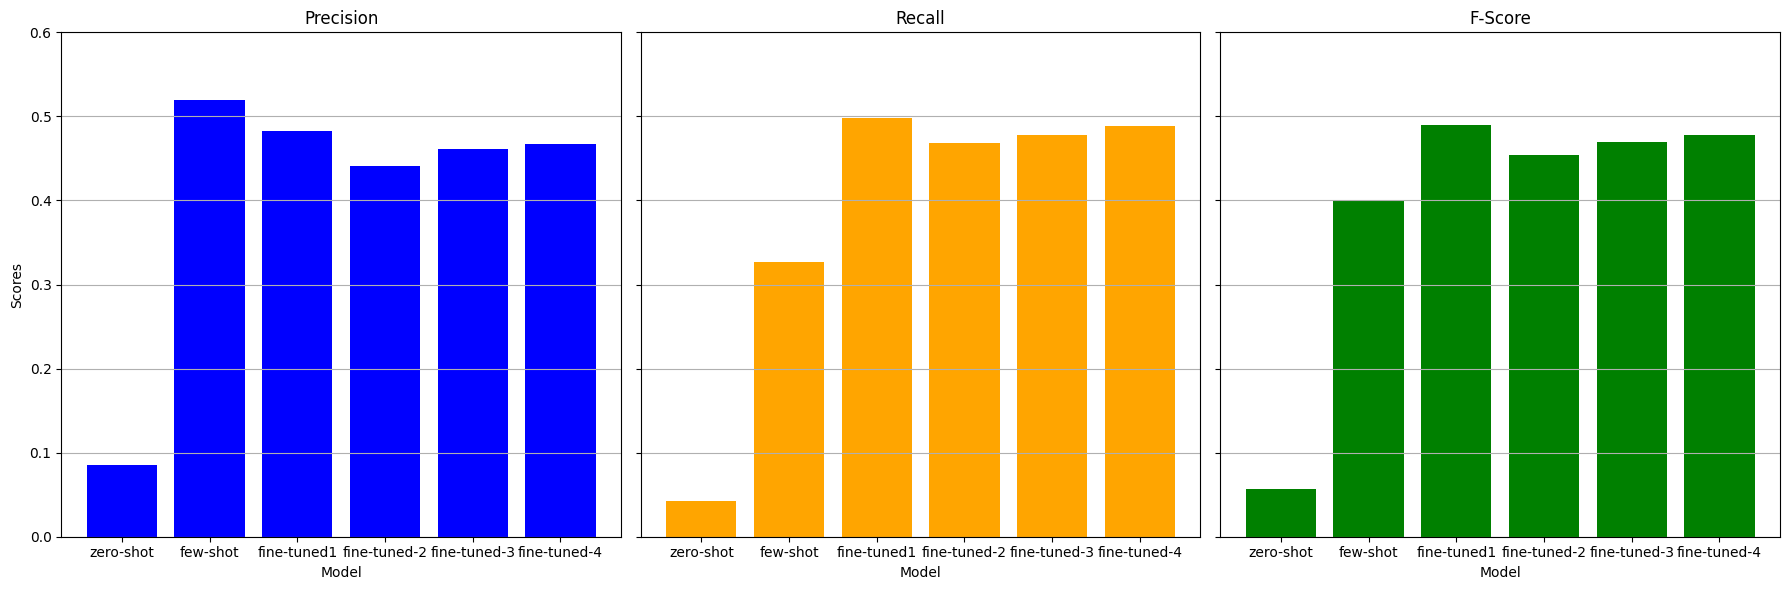

In [ ]:
plot_results(results)

Quick Notes:

*   Zero shot prompting performed quite poorly on the test datset. Though the model yielded relevant and coherent responses on the single test case.
*   Few shot prompting yielded significant improvements across all metrics when compared to zero shot.
*   Each of the fine-tuned models had comprable scores to the few shot results with lower precision but higher recall and f-scores.
*   The test and train datasets were obtained through a homework assignment. Performance metrics above 0.4 were considered a success. The head TA obtained scores of ~0.44 on all 3 metrics.
*   Improved upon work done for hw assignment. Attempted to solve problem with zero shot, few shot, and created additional fine-tuned models


Takeaways:

*   With the current datasets, there was no significant improvement between few shot and fine-tuned. If the current performance is acceptable, the extra cost of using a fine-tuned model would not be justified.
*   fine-tuned-1 used 100 training samples whereas models 2-4 used 200 training samples. Increasing the number of training samples had no impact on performance.
*   I was dissapointed in the performance and hoped to obtain higher performance metrics. It is worth noting that this is a very challening problem - the model needs to parse a biography and obtain an unknown number of attributes and unknown attribute types. Simplifications such as defining a number of attribute types that we are concerned about could reduce the complexity of the problem and lead to better results.
*   Increasing the number of training samples did not improve performance. The models performed similarly with 3 examples (few shot) as with 50-100 samples (fine-tuned). If I were to redo this project, I would focus on data quality. I would analyze the attributes most common amongst datasets and build a trainig datset that is smaller but encapsulates all important attributes.


